## Model 2

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import os
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

### Step 1 Merge feature data and price data

In [2]:
# Paths to the input files
feature_file_path = 'Data assignment 1/Feature data.csv'
prices_file_path = 'Data assignment 1/prices_merged_df_output.csv'

# Read the CSV files into pandas dataframes
feature_data_df = pd.read_csv(feature_file_path)
prices_data_df = pd.read_csv(prices_file_path)

# Feature scaling, same as model 1
scaler_standard = StandardScaler()

feature_data_df['Mean wind speed'] = scaler_standard.fit_transform(feature_data_df[['Mean wind speed']])
feature_data_df['Maximum temperature'] = scaler_standard.fit_transform(feature_data_df[['Maximum temperature']])

feature_data_df['Wind direction sin'] = np.sin(np.deg2rad(feature_data_df['Mean wind direction']))
feature_data_df['Wind direction cos'] = np.cos(np.deg2rad(feature_data_df['Mean wind direction']))

nominal_capacity = 30000
feature_data_df['AKI Kalby Active Power'] = feature_data_df['AKI Kalby Active Power'] / nominal_capacity

feature_data_df = feature_data_df.drop('Mean wind direction', axis=1)

feature_data_df['datetime'] = pd.to_datetime(feature_data_df['datetime'])
prices_data_df['HourDK'] = pd.to_datetime(prices_data_df['HourDK'])

# Merge the two datasets on their datetime columns, using an inner join to keep only matching rows
merged_df = pd.merge(feature_data_df, prices_data_df, left_on='datetime', right_on='HourDK', how='inner')

# Drop the redundant 'HourDK' column from the merged dataframe
merged_df = merged_df.drop(columns=['HourDK'])

# Define the output directory and file name
output_dir = 'Data assignment 1'
output_path = os.path.join(output_dir, 'Model2data.csv')

# Save the merged dataframe to a CSV file
merged_df.to_csv(output_path, index=False)


# Step 1 
## Clustering

In [17]:
target_filepath = 'Data assignment 1/TargetValues_Model2.csv'
target_values_df = pd.read_csv(target_filepath)

In [18]:
target_values_df

,HourDK,p_t_hat
0,2022-09-01 00:00:00,0.0
1,2022-09-01 01:00:00,1949.0
2,2022-09-01 02:00:00,0.0
3,2022-09-01 03:00:00,2711.0
4,2022-09-01 04:00:00,3126.0
...,...,...
1975,2022-11-22 08:00:00,30000.0
1976,2022-11-22 09:00:00,4595.0
1977,2022-11-22 10:00:00,3607.0
1978,2022-11-22 11:00:00,3100.0


In [19]:
target_values_df['datetime'] =pd.to_datetime(target_values_df['HourDK'])

In [20]:
target_values_df

,HourDK,p_t_hat,datetime
0,2022-09-01 00:00:00,0.0,2022-09-01 00:00:00
1,2022-09-01 01:00:00,1949.0,2022-09-01 01:00:00
2,2022-09-01 02:00:00,0.0,2022-09-01 02:00:00
3,2022-09-01 03:00:00,2711.0,2022-09-01 03:00:00
4,2022-09-01 04:00:00,3126.0,2022-09-01 04:00:00
...,...,...,...
1975,2022-11-22 08:00:00,30000.0,2022-11-22 08:00:00
1976,2022-11-22 09:00:00,4595.0,2022-11-22 09:00:00
1977,2022-11-22 10:00:00,3607.0,2022-11-22 10:00:00
1978,2022-11-22 11:00:00,3100.0,2022-11-22 11:00:00


In [21]:
target_values_df.drop('HourDK', axis=1, inplace=True)
target_values_df.set_index('datetime', inplace=True)

In [22]:
target_values_df.describe()

,p_t_hat
count,1980.000000
mean,10473.137879
std,13734.103002
min,-0.000000
25%,-0.000000
50%,1366.000000
75%,30000.000000
max,30000.000000


The descriptive statistics indicate that 25% of the data values are 0.0. This means that 25% of the time, at least, the offer should be 0. The 50th percentile being 1366 indicates that 25% of the data lies between 0 and 1366. The 75th percentile (or the third quartile, Q3) is 30000. This means that 75% of the data values are less than or equal to 30000. This indicates that the upper range of values is much higher than the median, pointing to the fact that there’s a significant jump in values for the highest 25% of the data. The 25th percentile being zero indicates that a significant portion of the data is centered around zero which leads us to the assumption that this would be a good cluster. Similarly, the 75th percentile being equal to the maximum (30,000) implies that the top 25% of the data values are all 30,000. This indicates that 30,000 is another significant grouping and likely forms a separate cluster.

Given this, we can reasonably conclude that the dataset likely has three clusters.

<Axes: ylabel='p_t_hat'>

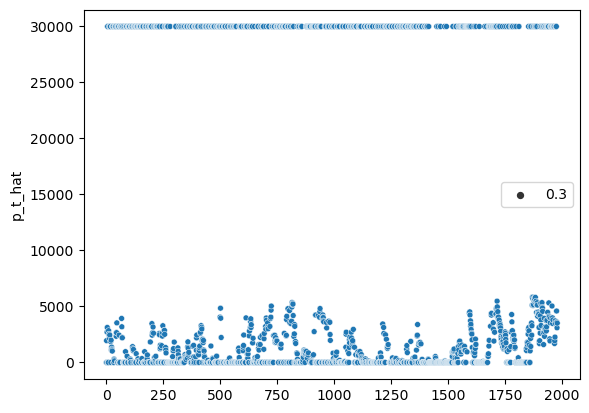

In [11]:
sns.scatterplot(x=target_values_df.index, y=target_values_df['p_t_hat'], size=0.3, data=target_values_df)

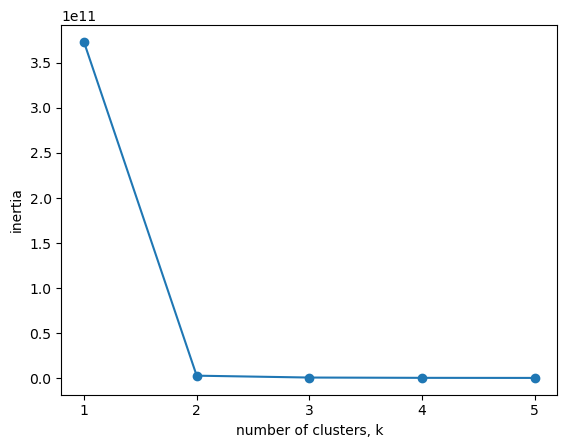

In [27]:
ks = range(1, 6)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,n_init='auto').fit(target_values_df)
    model.fit(target_values_df)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

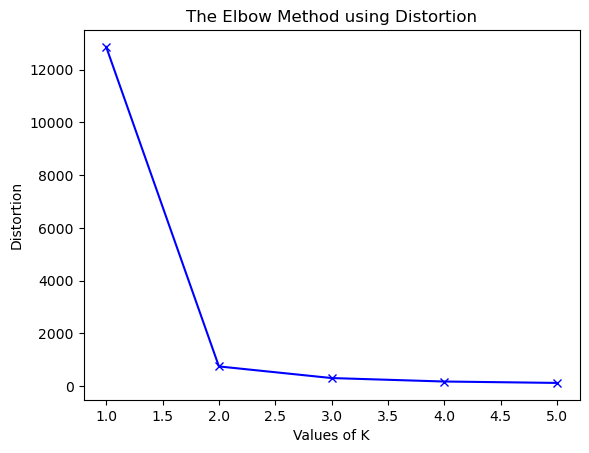

In [30]:
from scipy.spatial.distance import cdist
ks = range(1, 6)

distortions=[]
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k,n_init='auto').fit(target_values_df)
    model.fit(target_values_df)
    distortions.append(sum(np.min(cdist(target_values_df, model.cluster_centers_,'euclidean'), axis=1)) / target_values_df.shape[0])
    
plt.plot(ks, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

    

In [38]:
kmeans=KMeans(n_clusters=3,n_init='auto')
model=kmeans.fit(target_values_df)
target_values_df['Cluster']=kmeans.labels_

In [39]:
cluster_summary = target_values_df.groupby('Cluster').mean()
print(cluster_summary)

              p_t_hat
Cluster              
0          226.879692
1        30000.000000
2         3256.349481


Against expectation, there is no zero-cluster.


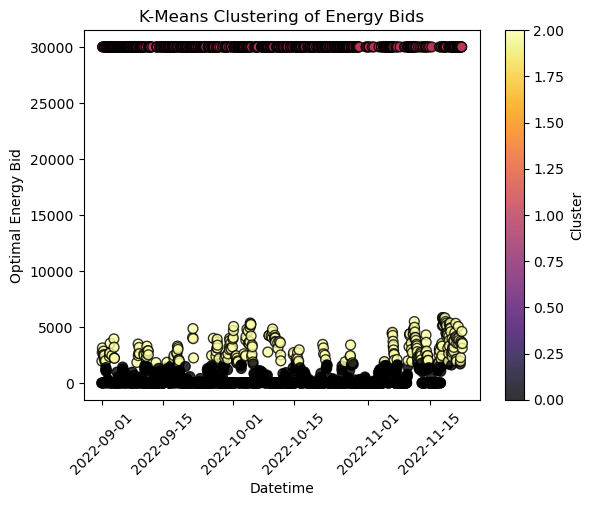

In [61]:
plt.scatter(target_values_df.index, target_values_df['p_t_hat'], c=target_values_df['Cluster'], s=50, alpha=0.8, edgecolors='black', cmap ='inferno')
plt.xlabel('Datetime', )
plt.ylabel('Optimal Energy Bid')
plt.xticks(rotation=45)
plt.title('K-Means Clustering of Energy Bids')
plt.colorbar(label='Cluster')
plt.show()

In [41]:
print(kmeans.cluster_centers_)

[[2.35811483e+02 1.80669856e+00]
 [3.00000000e+04 1.00000000e+00]
 [3.28759717e+03 1.44169611e+00]]


### Step 2

### Classification

In [3]:
data = pd.read_csv('Data assignment 1/Model2data.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

In [4]:
# Step 1: Define the hourly classification rule
def classify_action(row):
    if row['DA_PriceEUR'] > row['BalancingPriceUpEUR'] and row['DA_PriceEUR'] > row['BalancingPriceDownEUR']:
        return 1  # Sell more in day-ahead market
    elif row['DA_PriceEUR'] < row['BalancingPriceUpEUR'] or row['DA_PriceEUR'] < row['BalancingPriceDownEUR']:
        return 2  # Adjust in balancing market (buy/sell)
    else:
        return 3  # Balance between markets

# Apply the classification rule on an hourly basis
data['action_class'] = data.apply(classify_action, axis=1)

In [5]:
# Step 2: Define the objective function for hourly optimization (used for class 3)
def objective_function(predicted_p, actual_p, da_price, up_price, down_price):
    z_down = actual_p - predicted_p
    z_up = predicted_p - actual_p
    
    # Ensure non-negative values for z_down and z_up
    z_down = max(0, z_down)
    z_up = max(0, z_up)
    
    # Return negative to turn maximization problem into a minimization for scipy.optimize
    return -(da_price * predicted_p + (down_price * z_down - up_price * z_up))

In [6]:
# Step 3: Optimization for each hour depending on the action_class
def optimize_hourly_energy_production(row, nominal_capacity):
    actual_p = float(row['AKI Kalby Active Power'])  # Actual power production
    da_price = float(row['DA_PriceEUR'])  # Day-ahead price
    up_price = float(row['BalancingPriceUpEUR'])  # Up-regulation price
    down_price = float(row['BalancingPriceDownEUR'])  # Down-regulation price
    action_class = row['action_class']  # Classification

    # For class 1: Maximize day-ahead market (phat = nominal_capacity)
    if action_class == 1:
        return nominal_capacity
    
    # For class 2: Minimize production (phat = 0)
    elif action_class == 2:
        return 0
    
    # For class 3: Balance between day-ahead and balancing market (optimize phat)
    else:
        initial_predicted_p = actual_p  # Use actual power as an initial guess

        # Constraints: 0 < predicted_p <= nominal_capacity
        constraints = [{'type': 'ineq', 'fun': lambda p: p},  # predicted_p >= 0
                       {'type': 'ineq', 'fun': lambda p: nominal_capacity - p}]  # predicted_p <= nominal_capacity
        
        # Run the optimization for class 3
        result = minimize(objective_function, initial_predicted_p,
                          args=(actual_p, da_price, up_price, down_price),
                          constraints=constraints, method='SLSQP')
        
        # If optimization succeeds, return the optimal predicted_p, else fallback to initial guess
        return result.x[0] if result.success else initial_predicted_p
    
# Apply optimization for each hour
data['optimized_predicted_power'] = data.apply(lambda row: optimize_hourly_energy_production(row, nominal_capacity), axis=1)

In [7]:
# Step 4: Calculate hourly revenue based on the optimized predicted power
def calculate_hourly_revenue(row):
    actual_p = row['AKI Kalby Active Power']
    predicted_p = row['optimized_predicted_power']
    da_price = row['DA_PriceEUR']
    up_price = row['BalancingPriceUpEUR']
    down_price = row['BalancingPriceDownEUR']
    
    z_down = max(0, actual_p - predicted_p)
    z_up = max(0, predicted_p - actual_p)
    
    # Revenue is computed based on the objective function
    revenue = da_price * predicted_p + (down_price * z_down - up_price * z_up)
    return revenue

data['hourly_revenue'] = data.apply(calculate_hourly_revenue, axis=1)

In [8]:
# Step 5: Aggregate hourly revenue into daily revenue
data['date'] = data['datetime'].dt.date  # Extract the date
daily_revenue = data.groupby('date')['hourly_revenue'].sum().reset_index()

# Output only phat (optimized_predicted_power) for each hour and daily revenue
hourly_phat = data[['datetime', 'optimized_predicted_power']]  # phat for each hour

# Display the results
hourly_phat.head(), daily_revenue.head()


(             datetime  optimized_predicted_power
 0 2022-01-01 00:00:00                    30000.0
 1 2022-01-01 01:00:00                    30000.0
 2 2022-01-01 02:00:00                    30000.0
 3 2022-01-01 03:00:00                        0.0
 4 2022-01-01 04:00:00                    30000.0,
          date  hourly_revenue
 0  2022-01-01        0.074067
 1  2022-01-02        0.298774
 2  2022-01-03       -0.006036
 3  2022-01-04       12.240022
 4  2022-01-05        0.959337)

In [9]:
# Calculate total annual revenue
total_annual_revenue = daily_revenue['hourly_revenue'].sum()

# Output total annual revenue
print(f"Total Annual Revenue: {total_annual_revenue}")

Total Annual Revenue: 1503952.481695869
